<a href="https://colab.research.google.com/github/nataliavav/ML_SentimentClassification/blob/main/SentimentClassificationIMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Sentiment Classification for database of imdb reviews

-Preprocessing dataframe 

-Using tfidf to vectorize the review text into trainable data

-Training our classifier with training data using logistic regression

-Making predictions on validation data

-Attempting to achieve best f1,precision and recall scores in our validation data by changing the hyperparameters of logistic regression

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

Read and print imdb database file from drive

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/imdb-reviews.csv", sep='\t')
print(df)

                                                    url  rating  \
0      http://www.imdb.com/title/tt0120623/usercomments    10.0   
1      http://www.imdb.com/title/tt0043117/usercomments     9.0   
2      http://www.imdb.com/title/tt0043117/usercomments    10.0   
3      http://www.imdb.com/title/tt0835204/usercomments     4.0   
4      http://www.imdb.com/title/tt0499603/usercomments    10.0   
...                                                 ...     ...   
45003  http://www.imdb.com/title/tt0449000/usercomments     1.0   
45004  http://www.imdb.com/title/tt0109382/usercomments     1.0   
45005  http://www.imdb.com/title/tt0375560/usercomments     1.0   
45006  http://www.imdb.com/title/tt0165107/usercomments     1.0   
45007  http://www.imdb.com/title/tt0041513/usercomments    10.0   

                                                  review  
0      I thought this was a quiet good movie. It was ...  
1      Wagon Master is a very unique film amongst Joh...  
2      This film h

Preprocessing - Data Cleansing

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

def preprocess(df):
  df = df.drop('url', axis = 1)
  df['review'] = df['review'].str.lower()
  df['review'] = df['review'].str.replace("<br />", " ")
  df['review'] = df['review'].str.replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)    # Remove urls
  df['review'] = df['review'].str.replace('@[A-Za-z0-9_]+','')                                              # Remove mentions
  df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))                  # Remove emojis
  df['review'] = df['review'].str.replace('[^\w\s]','')                                                     # Remove punctuation
  df['review'] = df['review'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))   # Remove stop words
  return df

df1 = preprocess(df)
print(df1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-4-a8338bc6aa4e>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('@[A-Za-z0-9_]+','')                                              # Remove mentions
<ipython-input-4-a8338bc6aa4e>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review'] = df['review'].str.replace('[^\w\s]','')                                                     # Remove punctuation


      rating                                             review
0       10.0  thought quiet good movie fun watch liked best ...
1        9.0  wagon master unique film amongst john fords wo...
2       10.0  film near perfect film john ford made film mag...
3        4.0  gave 4 stars lot interesting themes many alrea...
4       10.0  movie really genuine random really hard find m...
...      ...                                                ...
45003    1.0  dont even know begin worth typing review quote...
45004    1.0  one worst movies saw 90s id often use benchmar...
45005    1.0  baldwin really stooped low make movies script ...
45006    1.0  liked watching mel gibson million dollar hotel...
45007   10.0  easily best cinematic version william faulkner...

[45008 rows x 2 columns]


Print the 20 most used words in the database

In [ ]:
most_used_words = pd.Series(' '.join(df1['review']).split()).value_counts()[:20]
print(most_used_words)

movie     79033
film      69432
one       46646
like      35623
good      26234
even      22402
would     21803
time      21669
really    21053
see       20650
story     20424
much      17425
well      17398
bad       16566
get       16560
great     16338
people    16234
also      16161
dont      15596
first     15575
dtype: int64


Preprocessing - Setting training and validation set.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split


X = df1.drop('rating', axis=1)
X = X.squeeze()
Y = df1[['rating']]                 # only keep the rating
Y = Y.replace(['7.0', '8.0', '9.0', '10.0'], 1)
Y = Y.replace(['0.0', '1.0', '2.0', '3.0', '4.0'], 0)


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=7)

Vectorize with Tfidf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfvectorizer = TfidfVectorizer(min_df=0.01)
X_train_tfidf = tfvectorizer.fit_transform(X_train)

X_val_tfidf = tfvectorizer.transform(X_val)

print(X_train_tfidf.shape)
print(X_val_tfidf.shape)

(38256, 1637)
(6752, 1637)


Example using what I think are the best hyperparameters with tfidf vectorizer.
Includes f1, precision and recall scores

In [ ]:
# Training
classifier = LogisticRegression(C=0.1, solver='newton-cg', penalty='l2', max_iter=2000)
classifier.fit(X_train_tfidf, np.ravel(Y_train))

#Results
predictions_train = classifier.predict(X_train_tfidf)
predictions_val = classifier.predict(X_val_tfidf)

print("Predictions by model:")
print(predictions_val)
print("Actual reviews (Positive or Negative):")
print(np.ravel(Y_val))

# F-Score

f1_train = f1_score(Y_train, predictions_train)
f1_val = f1_score(Y_val, predictions_val)

print("\nTraining Set:")
print("F1 Score:", f1_train)

print("\nValidation Set:")
print("F1 Score:", f1_val)
pscore = precision_score(predictions_val, Y_val, average='macro')
print('Precision:', pscore)
rscore = recall_score(predictions_val, Y_val, average='macro')
print('Recall:', rscore)

Predictions by model:
[0 0 1 ... 0 1 0]
Actual reviews (Positive or Negative):
[0 0 1 ... 1 1 0]

Training Set:
F1 Score: 0.8774872893385295

Validation Set:
F1 Score: 0.8737191513926973
Precision: 0.8702748959979616
Recall: 0.8710413052406454


Plot using best hyperparameters with tfidf vectorizer, to show that my model is neither over or underfitting

F1 Score Train: 0.8711111111111111
F1 Score Validation: 0.7111624973722934
F1 Score Train: 0.8740410789408561
F1 Score Validation: 0.8564814814814814
F1 Score Train: 0.8719590268886044
F1 Score Validation: 0.858181818181818
F1 Score Train: 0.8668309679612477
F1 Score Validation: 0.8591712547087801
F1 Score Train: 0.8702328827971317
F1 Score Validation: 0.8680826470163271
F1 Score Train: 0.8720077912758214
F1 Score Validation: 0.8698541094901054
F1 Score Train: 0.8744023224043715
F1 Score Validation: 0.8711213739356329
F1 Score Train: 0.875
F1 Score Validation: 0.8701805054151625
F1 Score Train: 0.8745110612375762
F1 Score Validation: 0.8717504332755632
F1 Score Train: 0.8762209401953504
F1 Score Validation: 0.873792009231213


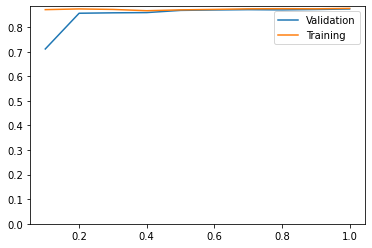

In [ ]:
import matplotlib.pyplot as plt

list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  
  # Training
  X, X_unused, y, y_unused = train_test_split(X_train_tfidf, Y_train, test_size=1 - (times * 0.1 + 0.005), random_state=0)

  classifier = LogisticRegression(C=0.1, solver='newton-cg', penalty='l2', max_iter=2000)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # Validation
  results = classifier.predict(X_val_tfidf)

  # Score
  f1_train = f1_score(y, results_train)
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_val, results)
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])